# Consulta a la API
Este código realiza un proceso automatizado para consultar y combinar datos históricos (2000–2024) de indicadores sociales (natalidad y desnutrición) en países de Sudamérica usando la API del Banco Mundial. 

In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm  # Progreso opcional

# --- Parámetros ---
sudamerica_nombres = [
    "Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador",
    "Paraguay", "Peru", "Uruguay", "Venezuela"
]

indicadores = {
    "SP.DYN.CBRT.IN": "Tasa de Natalidad (por 1000 habitantes)",
    "SN.ITK.DEFC.ZS": "Desnutrición (%)"
}
fecha = "2000:2024"

# --- Obtener lista de países disponibles ---
def obtener_paises_sudamericanos():
    url = "http://api.worldbank.org/v2/country?format=json&per_page=400"
    response = requests.get(url)
    data = response.json()
    paises = {
        pais["id"]: pais["name"]
        for pais in data[1]
        if pais["name"] in sudamerica_nombres
    }
    return paises

# --- Función para obtener datos de un país e indicador ---
def obtener_datos(pais_codigo, pais_nombre, indicador_codigo, indicador_nombre):
    url = (
        f"http://api.worldbank.org/v2/country/{pais_codigo}/indicator/{indicador_codigo}"
        f"?format=json&date={fecha}&per_page=100"
    )
    try:
        response = requests.get(url)
        data = response.json()
    except Exception:
        soup = BeautifulSoup(response.text, "html.parser")
        print(f"⚠️  Error al obtener datos para {pais_nombre} - {indicador_nombre}")
        return pd.DataFrame()

    if len(data) > 1:
        datos = [
            {
                "País": pais_nombre,
                "Año": int(d["date"]),
                "Indicador": indicador_nombre,
                "Valor": d["value"]
            }
            for d in data[1] if d["value"] is not None
        ]
        return pd.DataFrame(datos)
    else:
        return pd.DataFrame()

# --- Descarga de datos ---
def descargar_datos():
    paises = obtener_paises_sudamericanos()
    todos_los_datos = []

    print("🔄 Obteniendo datos desde la API del Banco Mundial...")
    for pais_codigo, pais_nombre in tqdm(paises.items()):
        for indicador_codigo, indicador_nombre in indicadores.items():
            df = obtener_datos(pais_codigo, pais_nombre, indicador_codigo, indicador_nombre)
            if not df.empty:
                todos_los_datos.append(df)

    if todos_los_datos:
        df_completo = pd.concat(todos_los_datos, ignore_index=True)
        return df_completo
    else:
        return pd.DataFrame()

# --- Ejecutar todo ---
df = descargar_datos()

# --- Pivotear tabla ---
if not df.empty:
    df_pivot = df.pivot_table(
        index=["Año", "País"],
        columns="Indicador",
        values="Valor"
    ).reset_index().sort_values(["País", "Año"])

    # --- Vista previa ---
    print("\n✅ Vista previa de los datos combinados:")
    print(df_pivot.head())
else:
    print("❌ No se encontraron datos disponibles.")


🔄 Obteniendo datos desde la API del Banco Mundial...


100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


✅ Vista previa de los datos combinados:
Indicador   Año       País  Desnutrición (%)  \
0          2000  Argentina               NaN   
9          2001  Argentina               2.9   
18         2002  Argentina               3.7   
27         2003  Argentina               4.3   
36         2004  Argentina               3.9   

Indicador  Tasa de Natalidad (por 1000 habitantes)  
0                                           19.328  
9                                           18.940  
18                                          18.702  
27                                          18.410  
36                                          18.295  


Guardando data frama en un excel

In [4]:
df_pivot.to_excel("indicadores_sudamerica.xlsx", index=False)


# Analisis grafico del indice de desnutricion por pais en los años 2001 - 2022
El siguiente grafico analiza de forma individual la evolucion de la desnutricion en cada pais.

Filtra solo los años entre 2001 y 2022.

Aísla solo los datos donde haya información de "Desnutrición (%)".

Crea un gráfico por cada país mostrando cómo ha cambiado ese indicador en el tiempo.

In [12]:
import matplotlib.pyplot as plt

# --- Filtrar datos entre 2001 y 2022 y solo el indicador de Desnutrición ---
df_filtrado = df_pivot[
    (df_pivot["Año"] >= 2001) &
    (df_pivot["Año"] <= 2022) &
    (df_pivot["Desnutrición (%)"].notna())
]

# --- Lista de países únicos ---
paises = df_filtrado["País"].unique()

# --- Crear y guardar un gráfico por país en la misma carpeta ---
for pais in paises:
    df_pais = df_filtrado[df_filtrado["País"] == pais]

    plt.figure(figsize=(10, 5))
    plt.plot(df_pais["Año"], df_pais["Desnutrición (%)"], marker='o', color='tomato', linewidth=2)

    plt.title(f"Índice de Desnutrición en {pais} (2001–2022)", fontsize=14)
    plt.xlabel("Año", fontsize=12)
    plt.ylabel("Desnutrición (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(df_pais["Año"], rotation=45)
    plt.tight_layout()

    # --- Guardar gráfico en la misma carpeta ---
    nombre_archivo = f"desnutricion_{pais.replace(' ', '_')}.png"
    plt.savefig(nombre_archivo)
    plt.close()



El siguiente grafico contrasta la evolucion del indice de desnutricion entre los paises.

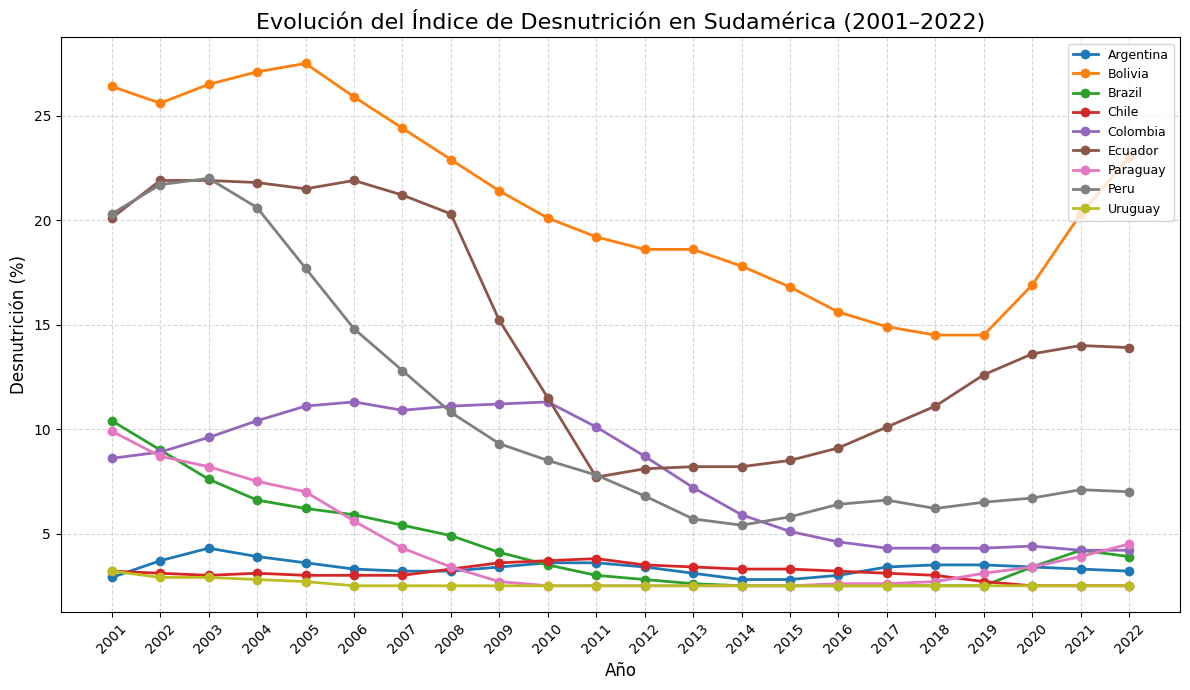

In [15]:
# --- Crear el gráfico ---
plt.figure(figsize=(12, 7))

for pais in paises:
    df_pais = df_filtrado[df_filtrado["País"] == pais]
    plt.plot(
        df_pais["Año"],
        df_pais["Desnutrición (%)"],
        marker='o',
        linewidth=2,
        label=pais
    )

plt.title("Evolución del Índice de Desnutrición en Sudamérica (2001–2022)", fontsize=16)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Desnutrición (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(2001, 2023), rotation=45)
plt.legend(loc="upper right", fontsize=9)
plt.tight_layout()

# --- Guardar como imagen ---
plt.savefig("desnutricion_comparativa_sudamerica.png")
plt.show()


# Analisis y conclusiones

🔸 Bolivia
Inició con una de las tasas más altas (~26%) y logró reducirla hasta ~14% hacia 2019.

Sin embargo, hay un fuerte repunte desde 2020, alcanzando ~20% en 2022.


🔸 Ecuador
Se mantuvo entre 20–22% hasta 2009, pero logró una reducción muy importante hasta casi 10% hacia 2013.

Luego muestra un ligero repunte nuevamente hasta 14% en 2022.

🔸 Perú
Exhibe una mejora notable y sostenida desde más del 20% en 2001 hasta menos del 6% en 2014.

Después se mantiene relativamente estable con pequeos incrementos marginales, indicando éxito sostenido en reducción de desnutrición.

🔸 Colombia y Paraguay
Ambos países también muestran una clara tendencia decreciente.

Paraguay destaca por una caída de 10% a casi 2.5% hacia 2015.

🔸 Argentina, Uruguay y Chile
Mantienen niveles bajos y estables de desnutrición (2.5%–4%) a lo largo del tiempo.

Sugiere sistemas alimentarios sólidos o problemas de desnutrición menos prevalentes.

🔸 Brasil
Reducción constante desde 10% (2001) a menos de 3% hacia 2015.

Luego una ligera estabilización, pero no se observan repuntes alarmantes.